In [ ]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()  # Set model to evaluation mode

# Global variables for storing activations and gradients
gradients = None
activations = None

# Forward hook to store activations
def forward_hook(module, input, output):
    global activations
    activations = output

# Backward hook to store gradients
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]  # Extract the first element of the tuple

# Register hooks on the last convolutional layer
target_layer = model.layer4[2].conv3
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Function to preprocess the input image
def preprocess_image(img_path):
    """
    - Loads an image and applies necessary preprocessing:
    - Resizing, conversion to tensor, and normalization.
    """
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Function to compute Grad-CAM++
def compute_gradcam_plus(img_path):
    """
    - Computes Grad-CAM++ heatmap by considering second-order gradients.
    - Provides better localization of the important regions.
    """
    img = preprocess_image(img_path)  # Preprocess image

    # Forward pass
    output = model(img)
    class_idx = torch.argmax(output).item()  # Get predicted class

    # Zero gradients
    model.zero_grad()

    # Backward pass for the predicted class
    one_hot = torch.zeros(output.shape)
    one_hot[0][class_idx] = 1
    output.backward(gradient=one_hot)  # Compute gradients

    # Compute Grad-CAM++ heatmap
    global gradients, activations
    grads = gradients.detach()  # Gradients from backpropagation
    activations = activations.detach()  # Feature maps from forward pass

    # Compute alpha values (Grad-CAM++ improvement)
    grads_power_2 = grads**2
    grads_power_3 = grads**3
    sum_grads = torch.sum(grads, dim=[2, 3], keepdim=True)

    alpha_num = grads_power_2
    alpha_denom = grads_power_2 * 2 + sum_grads * grads_power_3
    alpha_denom = torch.where(alpha_denom != 0, alpha_denom, torch.ones_like(alpha_denom))  # Avoid division by zero
    alphas = alpha_num / alpha_denom

    # Compute weighted activations
    weights = torch.sum(alphas * F.relu(grads), dim=[2, 3])
    gradcam_map = torch.sum(weights[:, :, None, None] * activations, dim=1).squeeze().numpy()

    # Apply ReLU and normalize heatmap
    heatmap = np.maximum(gradcam_map, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap, class_idx

# Function to overlay heatmap on the original image
def overlay_heatmap(img_path, heatmap):
    """
    - Resizes heatmap to match the original image.
    - Applies a color map for better visualization.
    - Blends the heatmap with the original image.
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 8-bit (0-255)
    heatmap = np.uint8(255 * heatmap)

    # Apply color map for visualization
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend original image with heatmap
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return img, heatmap, overlay

# Function to display results using Matplotlib
def display_results(img_path, heatmap, overlay, class_idx):
    """
    - Displays the original image, Grad-CAM++ heatmap, and overlay.
    """
    original = Image.open(img_path).convert('RGB')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(heatmap, cmap="jet")
    axes[1].set_title(f"Grad-CAM++ (Class {class_idx})")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Grad-CAM++ Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


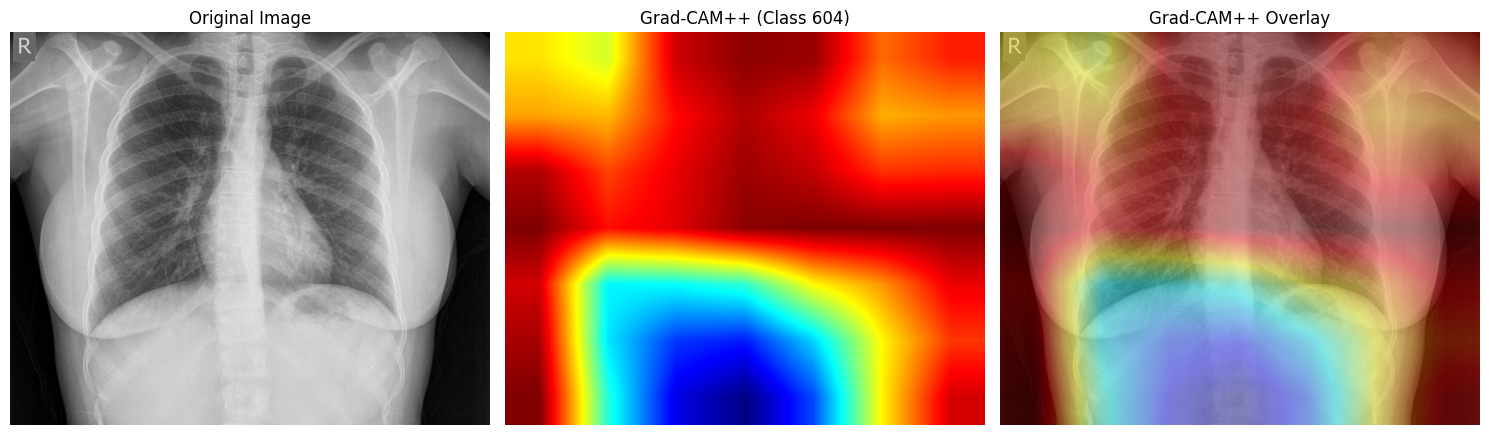

In [ ]:


# Load a medical image (e.g., chest X-ray)
img_path = "3-normal-healthy-chest-x-ray-photostock-israel.jpg"  # Replace with actual image path

# Compute Grad-CAM++ heatmap
heatmap, class_idx = compute_gradcam_plus(img_path)

# Generate overlay
original_img, heatmap_img, overlay_img = overlay_heatmap(img_path, heatmap)

# Display results
display_results(img_path, heatmap_img, overlay_img, class_idx)
